<a href="https://colab.research.google.com/github/karencfisher/Hotel-Cancellations/blob/master/notebooks/cancellations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
def convertTarget(df):
    df_copy = df.copy()
    cond = df_copy['reservation_status'] == 'No-Show'
    df_copy.loc[cond, 'reservation_status'] = 'Canceled'
    return df_copy
    

In [7]:
!pip install category_encoders==2.*
!wget https://raw.githubusercontent.com/karencfisher/Hotel-Cancellations/master/tools.py

import tools
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

url = 'https://raw.githubusercontent.com/karencfisher/Hotel-Cancellations/master/hotel_bookings.csv'
df = pd.read_csv(url)
df = tools.fixTarget(df)
df = convertTarget(df)

X = df.drop('reservation_status', axis=1)
y= df['reservation_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42,
                                                    stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.2,
                                                  random_state=42, stratify=y_train)

--2020-06-08 06:17:33--  https://raw.githubusercontent.com/karencfisher/Hotel-Cancellations/master/tools.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8279 (8.1K) [text/plain]
Saving to: ‘tools.py.2’

tools.py.2          100%[===================>]   8.08K  --.-KB/s    in 0s      

2020-06-08 06:17:33 (87.0 MB/s) - ‘tools.py.2’ saved [8279/8279]



In [3]:
tools.wrangleData(max_cardinality=50).transform(X_train).head()


,hotel,lead_time,arrival_date_week_number,adults,children,babies,meal,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,nights_stay
69573,City Hotel,189,22,2.0,0.0,0,BB,Groups,TA/TO,0,0,0,A,A,0,Non Refund,0,Transient,100.00,0,0,2.0
9066,Resort Hotel,79,44,2.0,0.0,0,BB,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,0,Transient,58.05,0,3,8.0
37865,Resort Hotel,87,26,1.0,0.0,0,BB,Corporate,TA/TO,0,0,0,A,I,2,No Deposit,0,Transient-Party,NaN,0,0,NaN
65344,City Hotel,55,13,2.0,0.0,0,BB,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,0,Transient,82.42,0,1,5.0
67378,City Hotel,14,18,2.0,0.0,0,SC,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,0,Transient,120.00,0,0,1.0


In [8]:
y_train.value_counts()

Check-Out    41697
Canceled     25161
Name: reservation_status, dtype: int64

In [9]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)

In [11]:
pipe = make_pipeline(tools.wrangleData(max_cardinality=50),
                     ce.OrdinalEncoder(),
                     SimpleImputer(),
                     SelectKBest(score_func=chi2, k='all'))

pipe.fit(X_train, y_train_enc)

Pipeline(memory=None,
         steps=[('wrangledata',
                 wrangleData(max_cardinality=50, remove_dates=True)),
                ('ordinalencoder',
                 OrdinalEncoder(cols=['hotel', 'meal', 'market_segment',
                                      'distribution_channel',
                                      'reserved_room_type',
                                      'assigned_room_type', 'deposit_type',
                                      'customer_type'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'hote...
                                         {'col': 'customer_type',
                                          'data_type': dtype('O'),
                                          'mapping': Transient          1
Contract           2
Transient-Party    3
Group              4
NaN               -2
dtype: int64}],
               

In [18]:
scores = pd.Series(pipe.named_steps['selectkbest'].scores_, 
                   pipe.named_steps['wrangledata'].columns_)

scores.sort_values(ascending=False)

lead_time                         582626.324725
days_in_waiting_list               18787.629353
previous_cancellations              6104.345450
total_of_special_requests           3915.958923
previous_bookings_not_canceled      3790.607223
booking_changes                     2640.130997
required_car_parking_spaces         2467.158677
deposit_type                        1409.064243
assigned_room_type                  1287.141439
customer_type                        574.711918
distribution_channel                 390.642237
is_repeated_guest                    237.348662
hotel                                192.453417
market_segment                        87.576957
babies                                70.389153
arrival_date_week_number              32.329470
nights_stay                           31.094507
adults                                30.136481
children                               4.788557
reserved_room_type                     3.767487
meal                                   3

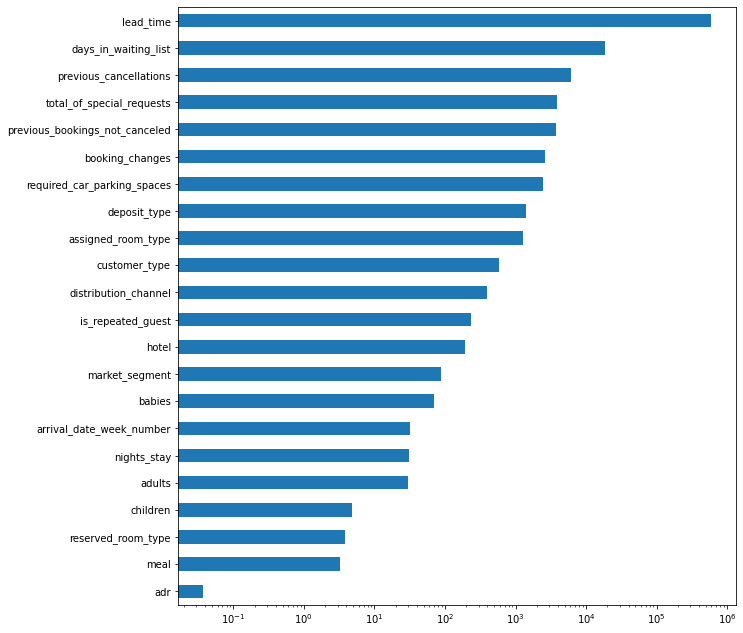

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, len(pipe.named_steps['wrangledata'].columns_) / 2))
scores.sort_values().plot.barh()
plt.xscale('log');

In [0]:
def getFeatures(scores, threshold):
    scores = scores.to_dict()
    features = []
    for key in scores:
        if scores[key] >= threshold:
          features.append(key)

    return features

In [37]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline

pipeline = make_imb_pipeline(tools.wrangleData(max_cardinality=50),
                         ce.OrdinalEncoder(),
                         SimpleImputer(),
                         SMOTE(random_state=42),
                         RandomForestClassifier(random_state=42,
                                                n_jobs=-1))

tools.tryModel(pipeline, X_train, y_train, X_val, y_val)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)




Train score = 99.24616351072422 %
Validate score = 85.88094525874963 %




'Confusion Matrix'

,Check-Out,Canceled
Check-Out,9508,917
Canceled,1443,4847


'Metrics'

,precision,recall,f1-score
Check-Out,0.868231,0.912038,0.889596
Canceled,0.840909,0.770588,0.804214


In [39]:
from sklearn.utils import compute_class_weight
weights = compute_class_weight('balanced', y_train.unique(), y_train)
weights

array([0.80171235, 1.32860379])

In [42]:
pipeline = make_imb_pipeline(tools.wrangleData(max_cardinality=50),
                         ce.OrdinalEncoder(),
                         SimpleImputer(),
                         SMOTE(random_state=42),
                         RandomForestClassifier(random_state=42,
                                                n_jobs=-1,
                                                class_weight={'Check-Out':weights[1],
                                                              'Canceled':weights[0]}))

tools.tryModel(pipeline, X_train, y_train, X_val, y_val)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)




Train score = 99.25214634000419 %
Validate score = 85.95871971283279 %




'Confusion Matrix'

,Check-Out,Canceled
Check-Out,9512,913
Canceled,1434,4856


'Metrics'

,precision,recall,f1-score
Check-Out,0.868993,0.912422,0.890178
Canceled,0.841740,0.772019,0.805374


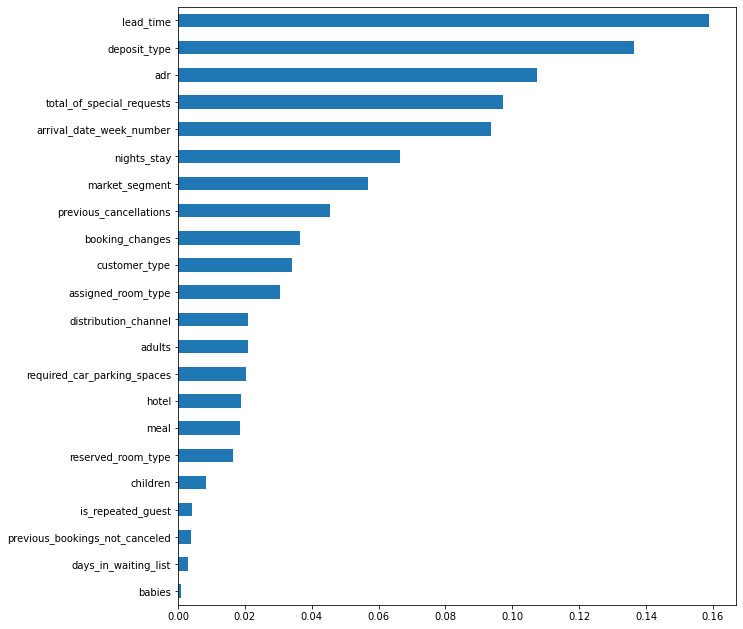

In [43]:
model = pipeline.named_steps['randomforestclassifier']
wrangle = pipeline.named_steps['wrangledata']
importances = pd.Series(model.feature_importances_, wrangle.columns_)

plt.figure(figsize=(10, len(wrangle.columns_) / 2))
importances.sort_values().plot.barh();

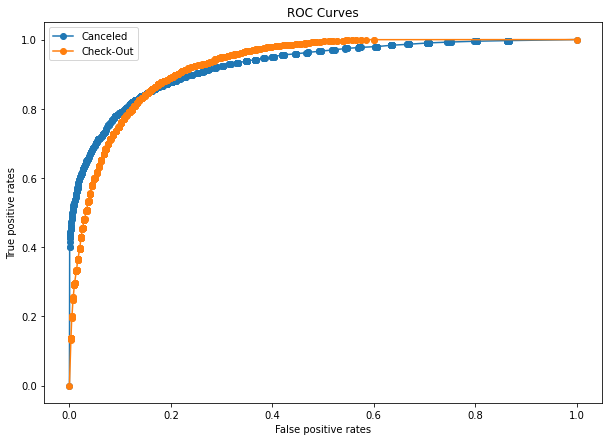

In [44]:
tools.ROCcurves(y_val, X_val, pipeline, model.classes_)